# Tier 1: Macro View - Quantifying the Landscape
This notebook conducts a high-level, quantitative analysis of the research domain. The goal is to identify the most prominent entities (papers, authors, venues), their key attributes, and overall trends. This establishes the "who, what, where, and when" of the literature.

In [1]:
import pandas as pd
from neo4j import GraphDatabase
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# --- Connect to Neo4j ---
load_dotenv()
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
driver = GraphDatabase.driver(URI, auth=AUTH)

# --- Helper Function to run queries and return a DataFrame ---
def query_to_dataframe(driver, query, **params):
    """
    This function executes a Cypher query against the database
    and returns the results as a pandas DataFrame.
    """
    with driver.session() as session:
        result = session.run(query, **params)
        return pd.DataFrame([r.data() for r in result])

print("Setup complete. Connected to Neo4j.")

Setup complete. Connected to Neo4j.


## 1. Foundational Papers
This section identifies the most influential papers in the corpus, measured by both external and internal citation counts.

### 1.1 Foundational Papers by Overall Citation Count
This analysis identifies papers with the highest external citation counts from the source metadata. These papers are considered highly influential in the broader academic landscape.

In [2]:
normalized_papers_df = pd.read_csv("./data/processed/normalized_papers.csv")

# Sort by citation_count (descending), then by influential_citation (descending) for tie-breaking
top_15_cited_df = normalized_papers_df.sort_values(
    by=["citation_count", "influential_citation_count"], 
    ascending=[False, False]
).head(15)

display(top_15_cited_df[["title", "year", "citation_count", "influential_citation_count"]])

,title,year,citation_count,influential_citation_count
315,Decision Transformer: Reinforcement Learning v...,2021.0,1747,301
1450,Reinforcement learning for demand response: A ...,2019.0,604,15
1317,Perceptual Learning Directs Auditory Cortical ...,2006.0,568,36
244,Reinforcement Knowledge Graph Reasoning for Ex...,2019.0,484,47
359,Social Influence as Intrinsic Motivation for M...,2018.0,462,50
1531,Working-memory capacity protects model-based l...,2013.0,432,34
628,Model-Free Real-Time EV Charging Scheduling Ba...,2019.0,393,23
1695,A Dynamic pricing demand response algorithm fo...,2018.0,360,20
1601,Deep Reinforcement Learning for Power System A...,2020.0,348,12
1846,Incentive-based demand response for smart grid...,2019.0,320,7


### 1.2 Foundational Papers by In-Corpus Citations
This query identifies papers most frequently cited by other papers within this specific corpus. This measures a paper's influence and centrality within this particular research domain.

In [3]:
# --- Query 2: Most Cited Papers (In-Corpus) ---
internal_citations_query = """
MATCH (p1:Paper)-[:CITES]->(p2:Paper)
RETURN p2.title AS foundational_paper, count(p1) AS citations_within_corpus
ORDER BY citations_within_corpus DESC
LIMIT 15
"""
print("\nFinding the 15 most cited papers by other papers in our corpus...")
internal_citations_df = query_to_dataframe(driver, internal_citations_query)
display(internal_citations_df)


Finding the 15 most cited papers by other papers in our corpus...


,foundational_paper,citations_within_corpus
0,Model-Free Real-Time EV Charging Scheduling Ba...,39
1,Reinforcement learning for demand response: A ...,31
2,Reinforcement Learning-Based Plug-in Electric ...,24
3,Incentive-based demand response for smart grid...,20
4,A Dynamic pricing demand response algorithm fo...,18
5,Optimal Demand Response Using Device-Based Rei...,18
6,CDDPG: A Deep-Reinforcement-Learning-Based App...,17
7,Reinforcement Learning for Real-Time Pricing a...,17
8,Definition and Evaluation of Model-Free Coordi...,16
9,Demand Response for Home Energy Management Usi...,16


## 2. Key Researchers

This section identifies the key researchers in the domain, measured by both productivity (number of papers) and influence (citations received from within the corpus).

### 2.1 Key Researchers by Publication Volume
This analysis identifies the most prolific authors by counting the number of papers they have authored in the dataset.

In [4]:
# --- Query 3: Most Prolific Authors ---
prolific_authors_query = """
MATCH (a:Author)-[:AUTHORED]->(p:Paper)
RETURN a.name AS author, count(p) AS papers_authored
ORDER BY papers_authored DESC
LIMIT 15
"""
print("\nFinding the 15 most prolific authors...")
prolific_authors_df = query_to_dataframe(driver, prolific_authors_query)
display(prolific_authors_df)


Finding the 15 most prolific authors...


,author,papers_authored
0,Yang Li,12
1,Qingyu Yang,11
2,Biwei Huang,10
3,C. Spanos,10
4,Lucas Spangher,10
5,B. Claessens,10
6,Kun Zhang,9
7,F. Ruelens,9
8,Hao Wang,9
9,Donghe Li,9


### 2.2 Key Researchers by In-Corpus Citations
To measure author influence within the domain, this query counts the total number of in-corpus citations received by all papers written by each author.

In [5]:
# --- Query 4: Author Influence by In-Corpus Citations ---
author_influence_query = """
MATCH (author:Author)-[:AUTHORED]->(paper:Paper)<-[:CITES]-(citingPaper:Paper)
RETURN author.name as author, count(citingPaper) as in_corpus_citations
ORDER BY in_corpus_citations DESC
LIMIT 15
"""
print("\nFinding the 15 most influential authors based on in-corpus citations...")
author_influence_df = query_to_dataframe(driver, author_influence_query)
display(author_influence_df)


Finding the 15 most influential authors based on in-corpus citations...


,author,in_corpus_citations
0,Renzhi Lu,65
1,S. Hong,58
2,B. Claessens,43
3,Haibo He,40
4,Hepeng Li,40
5,Zhiqiang Wan,40
6,D. Prokhorov,40
7,José R. Vázquez-Canteli,35
8,Z. Nagy,35
9,F. Ruelens,31


## 3. Top Publication Venues
This query identifies the journals and conferences where the research in the corpus is most frequently published.

In [6]:
# --- Query 5: Top Venues ---
top_venues_query = """
MATCH (p:Paper)-[:PUBLISHED_IN]->(v:Venue)
RETURN v.name AS venue, count(p) AS paper_count
ORDER BY paper_count DESC
LIMIT 15
"""
print("\nFinding the top 15 publication venues...")
top_venues_df = query_to_dataframe(driver, top_venues_query)
display(top_venues_df)


Finding the top 15 publication venues...


,venue,paper_count
0,arXiv.org,174
1,IEEE Access,62
2,IEEE Transactions on Smart Grid,55
3,Energies,47
4,IEEE Internet of Things Journal,24
5,Applied Energy,22
6,IEEE transactions on intelligent transportatio...,22
7,IEEE Transactions on Industrial Informatics,18
8,IEEE Power & Energy Society General Meeting,17
9,IEEE PES Innovative Smart Grid Technologies Co...,17


## 4. Dominant Fields of Study
This analysis shows the disciplinary distribution of the papers in the corpus, highlighting the most common fields of study.

In [7]:
# --- Query 6: Most common Fields of Study ---
papers_by_fos_query = """
MATCH (p:Paper)-[:HAS_FIELD]->(f:FieldOfStudy)
RETURN f.name AS field_of_study, count(p) AS number_of_papers
ORDER BY number_of_papers DESC
LIMIT 10
"""
print("\nFinding the top 10 most common fields of study...")
papers_by_fos_df = query_to_dataframe(driver, papers_by_fos_query)
display(papers_by_fos_df)


Finding the top 10 most common fields of study...


,field_of_study,number_of_papers
0,Computer Science,1083
1,Engineering,145
2,Medicine,127
3,Mathematics,83
4,Psychology,65
5,Physics,23
6,Biology,23
7,Economics,16
8,Business,11
9,Environmental Science,3


## 5. Publication Timeline
This query shows the volume of publications per year, illustrating the evolution and growth of the research field over time.


Calculating publication counts per year...


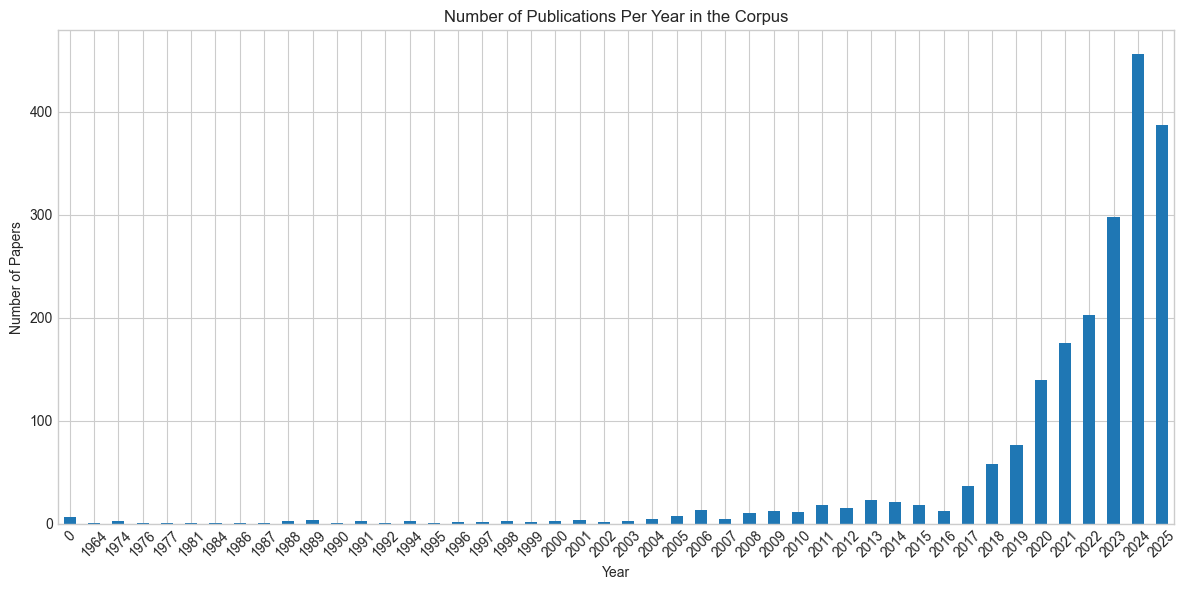

In [8]:
# --- Query 7: Publications Over Time ---
timeline_query = """
MATCH (p:Paper)
WHERE p.year IS NOT NULL
RETURN p.year AS publication_year, count(p) AS number_of_papers
ORDER BY publication_year ASC
"""
print("\nCalculating publication counts per year...")
timeline_df = query_to_dataframe(driver, timeline_query)

# Plotting the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
timeline_df.plot(kind='bar', x='publication_year', y='number_of_papers', ax=ax, legend=False)
ax.set_title('Number of Publications Per Year in the Corpus')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()